In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [3]:
def ISOdate(date):
    return pd.Timestamp(date).strftime('%Y-%m-%d')
    
def cleanup_frame(df):
    df.columns=itertools.chain(map(str.lower,df.columns[:4]),map(ISOdate,df.columns[4:]))
    return df.rename(columns={'province/state':'state','country/region':'country'}).groupby('country').sum().drop(columns=['lat','long'])

def cleanup_frame_US(kind,df):
    date_start_column=11
    drop_columns=['uid', 'iso2', 'iso3', 'code3', 'fips', 'admin2','lat','long','combined_key']
    if kind == 'deaths':
        date_start_column+=1
        drop_columns.append('population')
    df.columns=itertools.chain(map(str.lower,df.columns[:date_start_column]),map(ISOdate,df.columns[date_start_column:]))
    return df.rename(columns={'province_state':'state','country_region':'country','long_':'long'}).drop(columns=drop_columns).groupby('state').sum()

In [4]:
data={}
for df_name in ('confirmed','deaths','recovered'):
    data[df_name]=cleanup_frame(pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{df_name}_global.csv'))
    if df_name != 'recovered':
        data[df_name+'_US']=cleanup_frame_US(df_name,pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{df_name}_US.csv'))

In [5]:
data['infections']=data['confirmed'].sub(data['recovered'].add(data['deaths']))
data['infections_US']=data['confirmed_US'].sub(data['deaths_US'])

In [6]:
keys=list(data.keys()) # Prevent keys from changing when we add items to dictionary in for loop
for key in keys:
    data[key+'_c14davg']=data[key].rolling(window=14,axis='columns',min_periods=1).mean()

In [7]:
def chart(kind,countries,file=None,logarithm=False):
    plt.figure()
    plt.suptitle(kind)
    if isinstance(countries,list):
        for country in countries:
            data[kind].loc[country].plot(logy=logarithm)
        plt.legend(loc='upper left')
    else:
        data[kind].loc[countries].plot(logy=logarithm)
    if file:
        plt.savefig(file)
    else:
        plt.show()



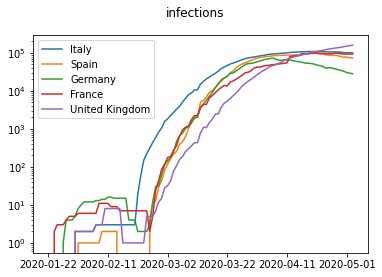

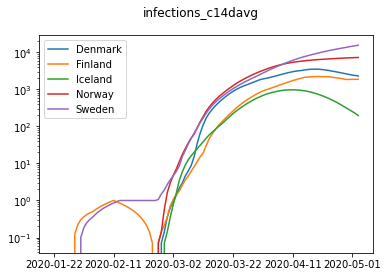

In [10]:
chart('infections',['Italy','Spain','Germany','France','United Kingdom'],logarithm=True)
chart('infections_c14davg',['Denmark','Finland','Iceland','Norway','Sweden'],logarithm=True)

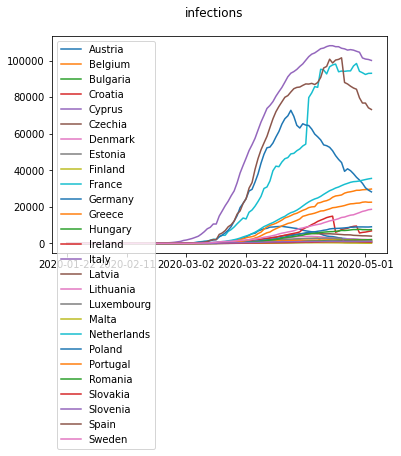

In [8]:
EU_countries=["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"]
chart('infections',EU_countries)

In [13]:

def sort_countries(kind,countries,column):
    return sorted(countries, key=lambda x:data[kind].at[x,column],reverse=True)

In [15]:
data.keys()

dict_keys(['confirmed', 'confirmed_US', 'deaths', 'deaths_US', 'recovered', 'infections', 'infections_US', 'confirmed_c14davg', 'confirmed_US_c14davg', 'deaths_c14davg', 'deaths_US_c14davg', 'recovered_c14davg', 'infections_c14davg', 'infections_US_c14davg'])

In [23]:
def countries_order(kind):
    df=pd.DataFrame()
    for day in data[kind].columns:
        df[day]=sort_countries(kind,data[kind].index,day)
    return df

In [26]:
df=countries_order('confirmed').head(10)

In [28]:
df['2020-03-22']

0             China
1             Italy
2                US
3             Spain
4           Germany
5              Iran
6            France
7      Korea, South
8       Switzerland
9    United Kingdom
Name: 2020-03-22, dtype: object

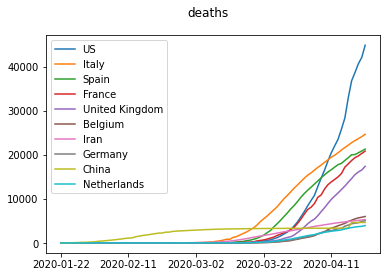

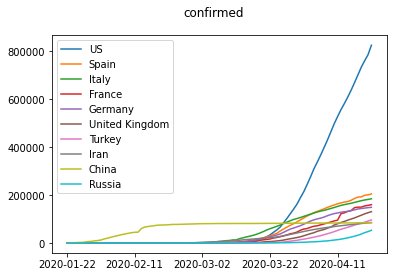

In [39]:
topchart('deaths',file='deaths.png')
topchart('confirmed',file='confirmed.png')

In [8]:
df=data['infections']

In [27]:
past_curve=df[df[df.columns[-1]]<df.max(1)].index

In [25]:
file=open("test","w")

In [29]:
file.writelines(map(lambda x:"# {0:s}\n".format(x),past_curve))

In [30]:
file.close()
